In [1]:
import os
import matplotlib.pyplot as plt
import torch
import numpy as np

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.6')
pyro.set_rng_seed(0)
torch.set_default_tensor_type(torch.DoubleTensor)

/home/jasmine/miniforge3/envs/uncertainty_quant/lib/python3.12/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1706712279749/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
# note that this helper function does three different things:
# (i) plots the observed data;
# (ii) plots the predictions from the learned GP after conditioning on data;
# (iii) plots samples from the GP prior (with no conditioning on observed data)


def plot(
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None,
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = dist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(-0.5, 5.5)

In [9]:
# Set random seed for reproducibility
np.random.seed(42)

# Create a function for generating data
def hidden_function(x):
    return x + 0.3 * np.sin(2*np.pi*x) + 0.3*np.sin(4*np.pi*x)

N = 70
# Generate data
X = torch.from_numpy(np.hstack([np.linspace(-0.2, 0.2, N//2), np.linspace(0.6, 1, N//2)]))
noise = 0.02 * np.random.randn(X.shape[0])
y = hidden_function(X+noise)

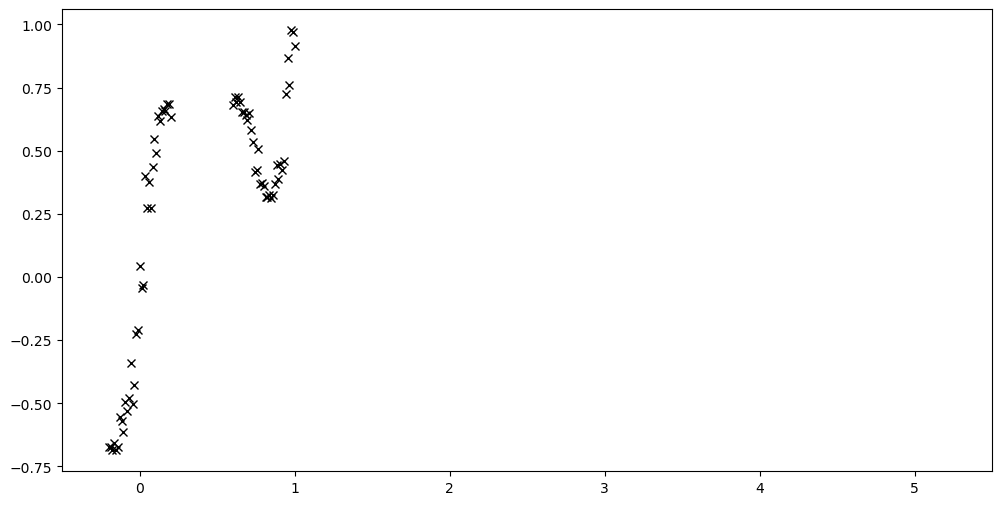

In [11]:
#N = 20
#X = dist.Uniform(0.0, 5.0).sample(sample_shape=(N,))
#y = 0.5 * torch.sin(3 * X) + dist.Normal(0.0, 0.2).sample(sample_shape=(N,))

plot(plot_observed_data=True)  # let's plot the observed data

In [12]:
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(0.05)
)
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.2))


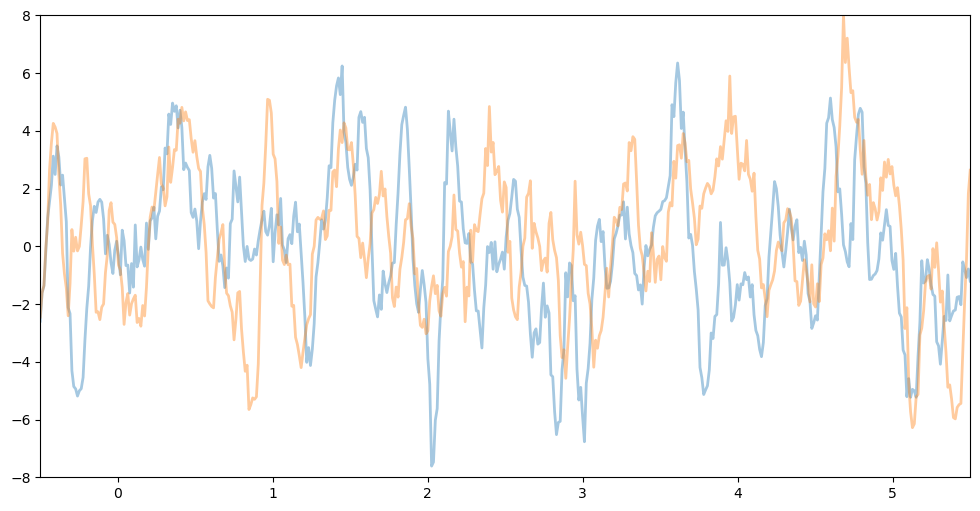

In [13]:
plot(model=gpr, kernel=kernel, n_prior_samples=2)
_ = plt.ylim((-8, 8))


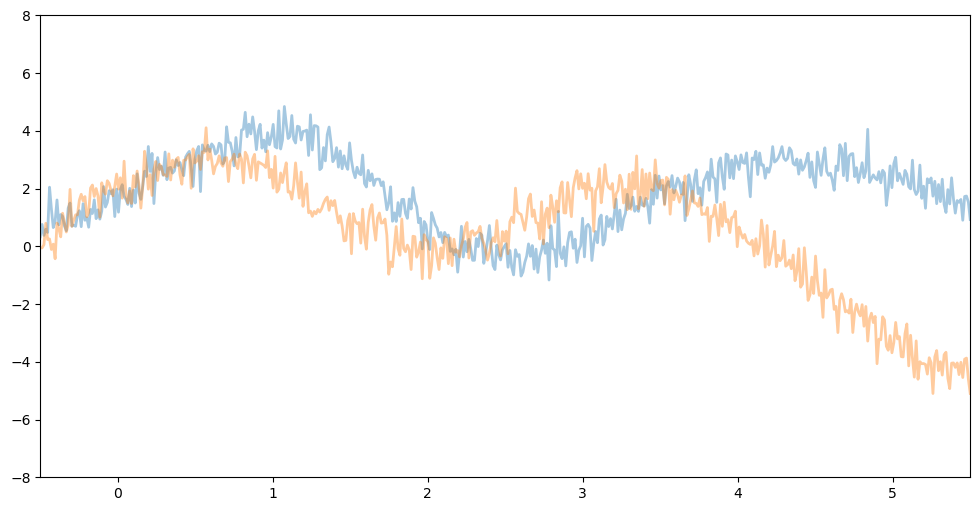

In [14]:
kernel2 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(6.0), lengthscale=torch.tensor(1)
)
gpr2 = gp.models.GPRegression(X, y, kernel2, noise=torch.tensor(0.2))
plot(model=gpr2, kernel=kernel2, n_prior_samples=2)
_ = plt.ylim((-8, 8))

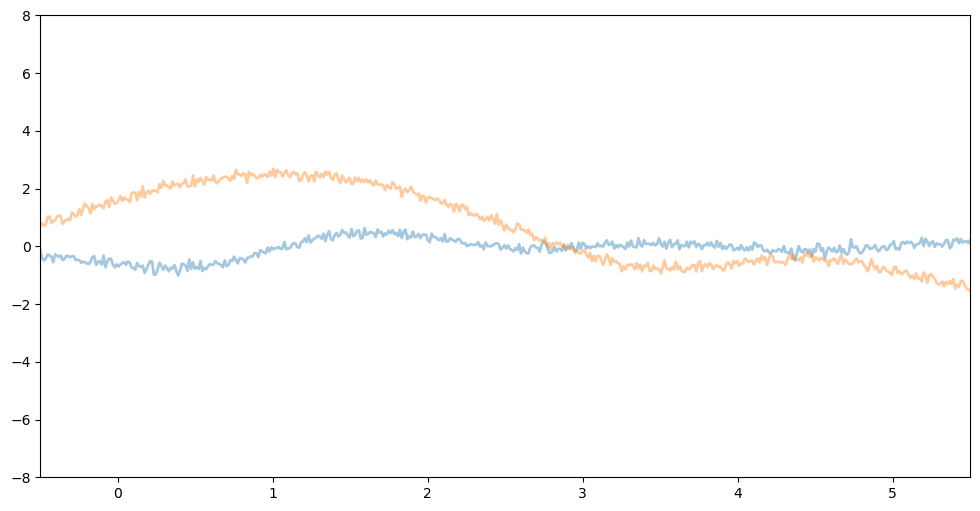

In [15]:
kernel3 = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(1)
)
gpr3 = gp.models.GPRegression(X, y, kernel3, noise=torch.tensor(0.01))
plot(model=gpr3, kernel=kernel3, n_prior_samples=2)
_ = plt.ylim((-8, 8))

In [16]:
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
variances = []
lengthscales = []
noises = []
num_steps = 2000 if not smoke_test else 2
for i in range(num_steps):
    variances.append(gpr.kernel.variance.item())
    noises.append(gpr.noise.item())
    lengthscales.append(gpr.kernel.lengthscale.item())
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

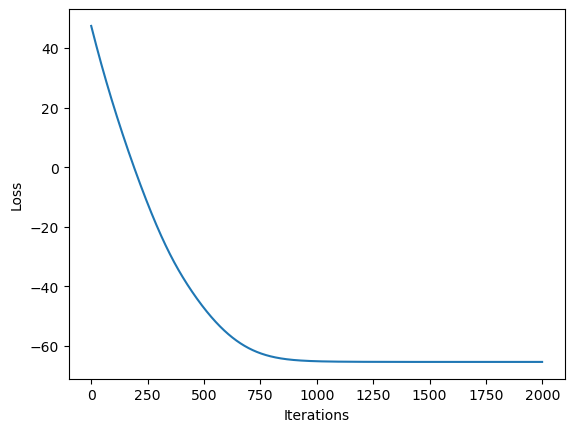

In [17]:
# let's plot the loss curve after 2000 steps of training
def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    _ = plt.ylabel("Loss")  # supress output text


plot_loss(losses)



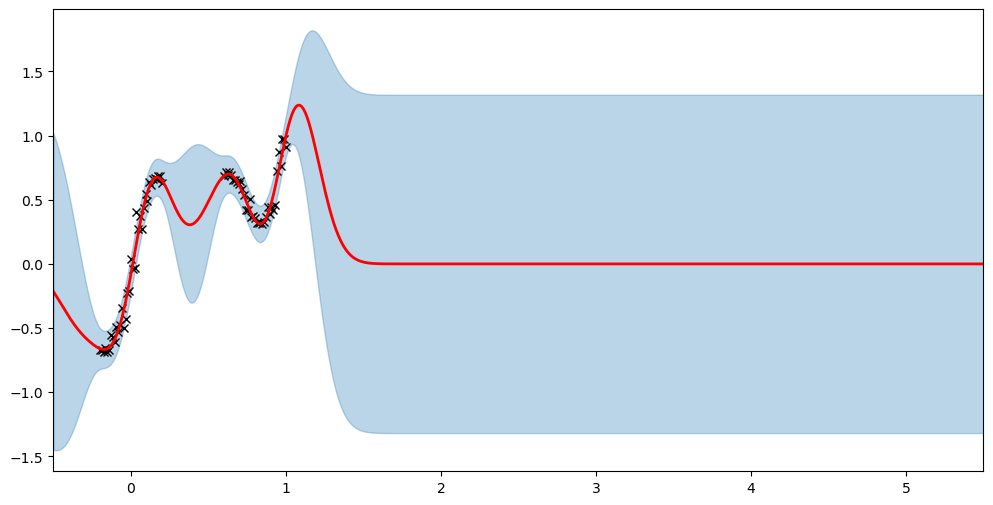

In [18]:
plot(model=gpr, plot_observed_data=True, plot_predictions=True)

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))


def update(iteration):
    pyro.clear_param_store()
    ax.cla()
    kernel_iter = gp.kernels.RBF(
        input_dim=1,
        variance=torch.tensor(variances[iteration]),
        lengthscale=torch.tensor(lengthscales[iteration]),
    )
    gpr_iter = gp.models.GPRegression(
        X, y, kernel_iter, noise=torch.tensor(noises[iteration])
    )
    plot(model=gpr_iter, plot_observed_data=True, plot_predictions=True, ax=ax)
    ax.set_title(f"Iteration: {iteration}, Loss: {losses[iteration]:0.2f}")


anim = FuncAnimation(fig, update, frames=np.arange(0, num_steps, 30), interval=100)
plt.close()

anim.save("../source/_static/img/gpr-fit.gif", fps=60)



MovieWriter ffmpeg unavailable; using Pillow instead.


FileNotFoundError: [Errno 2] No such file or directory: '../source'